<a href="https://colab.research.google.com/github/x1001000/books-chinese-networkx/blob/main/Co_occurrence_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 安裝

In [ ]:
# 安裝 CKIP 套件
! pip install ckiptagger

# 下載

In [ ]:
# 下載 CKIP 模型
from ckiptagger import data_utils
data_utils.download_data_gdown("./")    # Google Drive 載點（有時無法下載）
#data_utils.download_data_url("./")         # CKIP Lab 載點（較慢）

Permission denied: https://drive.google.com/uc?id=1efHsY16pxK0lBD2gYCgCTnv1Swstq771
Maybe you need to change permission over 'Anyone with the link'?


In [ ]:
# 下載中文字型
! wget https://github.com/googlefonts/noto-cjk/raw/master/NotoSansCJK-Regular.ttc
# 解決 networkx 繪圖無法顯示中文的問題
! cp NotoSansCJK-Regular.ttc /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf

--2020-12-04 02:17:54--  https://github.com/googlefonts/noto-cjk/raw/master/NotoSansCJK-Regular.ttc
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/googlefonts/noto-cjk/master/NotoSansCJK-Regular.ttc [following]
--2020-12-04 02:17:55--  https://raw.githubusercontent.com/googlefonts/noto-cjk/master/NotoSansCJK-Regular.ttc
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19981104 (19M) [application/octet-stream]
Saving to: ‘NotoSansCJK-Regular.ttc.1’

NotoSansCJK-Regular 100%[===================>]  19.05M  43.1MB/s    in 0.4s    

2020-12-04 02:17:58 (43.1 MB/s) - ‘NotoSansCJK-Regular.ttc.1’ saved [1998

In [ ]:
# 下載博客來中文書各分類 csv 檔
! git clone https://github.com/x1001000/books-chinese-networkx

fatal: destination path 'books-chinese-networkx' already exists and is not an empty directory.


# 匯入

In [ ]:
# 匯入斷詞、詞性標記、命名實體識別的三個工具
from ckiptagger import WS, POS, NER
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

In [ ]:
# 匯入其餘套件
import re
import itertools
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from scipy.spatial import distance
import networkx as nx

# 斷詞統計、共現網路

In [ ]:
#@title 輸入
分類細項 = "文學小說 > 翻譯文學 > 日本文學" #@param {type:"string"}
分類細項 = 分類細項.replace(' ', '')
分類細項 = 分類細項.replace('>', '_')
出版年段 = "2015 ~ 2019" #@param {type:"string"}
出版年段 = 出版年段.replace(' ', '')
year_fr = int(出版年段[:4])
year_to = int(出版年段[-4:])
字詞出現次數大於 =  15#@param {type:"integer"}

In [ ]:
books = pd.read_csv(f'books-chinese-networkx/博客來-中文書_{分類細項}.csv')
books['出版年'] = pd.Series(int(date[:4]) for date in books['出版日期'])
books[(year_fr <= books['出版年']) & (books['出版年'] <= year_to)][['書名', '出版年']]

,書名,出版年
230,下町火箭：GHOST,2019
231,日輪之翼,2019
232,水族館女孩02 擦身而過的跳躍,2019
233,我的母親手記,2019
234,最後的證人,2019
...,...,...
1391,繼父(獨步九週年紀念版),2015
1392,麵包、湯與貓咪日和,2015
1393,落櫻繽紛,2015
1394,愛的成人式,2015


In [ ]:
# 銷售用詞及其括號
tags_to_remove = [
    r'\(.+版\)',
    r'（.+版）',
    r'﹝.+版﹞',
    r'【.+版】',
    r'〈.+版〉',
    r'《.+版》',

    r'\(全.+冊\)',
    r'（全.+冊）',
    r'﹝全.+冊﹞',
    r'【全.+冊】',
    r'〈全.+冊〉',
    r'《全.+冊》',

    r'\([上下]冊?\)',
    r'（[上下]冊?）',
    r'﹝[上下]冊?﹞',
    r'【[上下]冊?】',
    r'〈[上下]冊?〉',
    r'《[上下]冊?》',

    r'\(.*(新譯|譯本|導讀|精裝|線裝|扉頁|套組|套書|書衣|書票|附贈|贈品|海報|分售).*\)',
    r'（.*(新譯|譯本|導讀|精裝|線裝|扉頁|套組|套書|書衣|書票|附贈|贈品|海報|分售).*）',
    r'﹝.*(新譯|譯本|導讀|精裝|線裝|扉頁|套組|套書|書衣|書票|附贈|贈品|海報|分售).*﹞',
    r'【.*(新譯|譯本|導讀|精裝|線裝|扉頁|套組|套書|書衣|書票|附贈|贈品|海報|分售).*】',
    r'〈.*(新譯|譯本|導讀|精裝|線裝|扉頁|套組|套書|書衣|書票|附贈|贈品|海報|分售).*〉',
    r'《.*(新譯|譯本|導讀|精裝|線裝|扉頁|套組|套書|書衣|書票|附贈|贈品|海報|分售).*》',    ]

In [ ]:
# 去除銷售用詞及其括號，再刪除重複書名
titles = []
removed = []
for title in books[(year_fr <= books['出版年']) & (books['出版年'] <= year_to)]['書名']:
    for tag in tags_to_remove:
        match = re.search(tag, title)
        if match:
            removed.append(title)
            title = title.replace(match.group(0), '')
    titles.append(title)
print('去除銷售用詞及其括號，再刪除重複書名')
print(f'前：{len(titles)} 本')
print(f'後：{len(set(titles))} 本')

去除銷售用詞及其括號，再刪除重複書名
前：1166 本
後：1133 本


In [ ]:
# 分析使用的詞類
pos_to_keep = [
    'A',
    'N',
    'Nv',
    'Vi',
    'Vt',
    'FW',]

In [ ]:
# 詞類對應 http://ckipsvr.iis.sinica.edu.tw/cat.htm
table = '''
A	A
Caa	C
Cab	POST
Cba	POST
Cbb	C
D	ADV
DE	T
Da	ADV
Dfa	ADV
Dfb	ADV
Di	ASP
Dk	ADV
FW	FW
I	T
Na	N
Nb	N
Nc	N
Ncd	N
Nd	N
Nep	DET
Neqa	DET
Neqb	POST
Nes	DET
Neu	DET
Nf	M
Ng	POST
Nh	N
Nv	Nv
P	P
SHI	Vt
T	T
VA	Vi
VAC	Vt
VB	Vi
VC	Vt
VCL	Vt
VD	Vt
VE	Vt
VF	Vt
VG	Vt
VH	Vi
VHC	Vt
VI	Vi
VJ	Vt
VK	Vt
VL	Vt
V_2	Vt'''

pos_reduced = {}
for k_v in table.strip().split('\n'):
    k,v = k_v.split()
    pos_reduced[k] = v

In [ ]:
# CKIP斷詞，若非分析使用的詞類，則出現次數歸零，統計字詞出現次數
term_count = {}
ws_of_titles = ws(set(titles))
pos_of_titles = pos(ws_of_titles)
for ws_of_title, pos_of_title in zip(ws_of_titles, pos_of_titles):
    for w, p in zip(ws_of_title, pos_of_title):
        if f'{w}({p})' not in term_count:
            term_count[f'{w}({p})'] = 1
        else:
            term_count[f'{w}({p})'] += 1
for term in term_count:
    term_pos = re.search(r'\((.+)\)', term).group(1)
    if term_pos not in pos_reduced:
        term_count[term] = 0
    elif pos_reduced[term_pos] not in pos_to_keep:
        term_count[term] = 0
term_count_df = pd.DataFrame({'字詞': [term for term in term_count], '出現次數': [count for count in term_count.values()]})
term_count_df

,字詞,出現次數
0,Burn(FW),1
1,.(PERIODCATEGORY),0
2,骨音(Na),1
3,：(COLONCATEGORY),0
4,池袋(Nc),10
...,...,...
2849,奇想(Na),1
2850,江河(Na),1
2851,流(VA),1
2852,甲午戰爭(Nb),1


In [ ]:
term_count_df[term_count_df['出現次數'] > 0].sort_values(by='出現次數', ascending=False)

,字詞,出現次數
56,日本(Nc),71
26,我(Nh),62
142,經典(Na),40
105,小說(Na),39
274,文學(Na),37
...,...,...
1321,回(VCL),1
1318,波斯(Nc),1
1316,宮殿(Na),1
1315,黃金(Na),1


In [ ]:
## 統計
#term_count_df[['出現次數']].describe()

In [ ]:
df = term_count_df[term_count_df['出現次數'] > 字詞出現次數大於].sort_values(by='出現次數', ascending=False)
print(f'出現次數大於 {字詞出現次數大於} 的字詞有 {len(df)} 個')

出現次數大於 15 的字詞有 21 個


In [ ]:
fig = px.bar(df, color='出現次數', color_continuous_scale=px.colors.sequential.Viridis, x='字詞', y='出現次數')
fig.show()

In [ ]:
vocab    = dict(zip(df['字詞'], range(len(df))))
re_vocab = dict(zip(range(len(df)), df['字詞']))#list(df['字詞'])
assert len(df) == len(vocab) == len(re_vocab)

In [ ]:
C_ws_of_titles = [list(itertools.combinations(title, 2)) for title in ws_of_titles]
C_pos_of_titles = [list(itertools.combinations(title, 2)) for title in pos_of_titles]
cooccurrence_matrix = np.zeros((len(df), len(df)))
for C_ws_of_title, C_pos_of_title in zip(C_ws_of_titles, C_pos_of_titles):
    for w, p in zip(C_ws_of_title, C_pos_of_title):
        if f'{w[0]}({p[0]})' in vocab and f'{w[1]}({p[1]})' in vocab:
            cooccurrence_matrix[vocab[f'{w[0]}({p[0]})'], vocab[f'{w[1]}({p[1]})']] += 1
            cooccurrence_matrix[vocab[f'{w[1]}({p[1]})'], vocab[f'{w[0]}({p[0]})']] += 1
for i in range(len(df)):
    cooccurrence_matrix[i, i] /= 2
#cooccurrence_matrix

In [ ]:
# https://www.kaggle.com/itoeiji/simple-co-occurrence-network
#jaccard_matrix = 1 - distance.cdist(cooccurrence_matrix, cooccurrence_matrix, 'jaccard')
#jaccard_matrix

In [ ]:
pairs = []
edges = []
for i in range(len(df)):
    for j in range(i+1, len(df)):
        #jaccard = jaccard_matrix[i, j]
        #if jaccard > 0:
        #    pairs.append([re_vocab[i], re_vocab[j], term_count[re_vocab[i]], term_count[re_vocab[j]], jaccard])
        cooccurrence = cooccurrence_matrix[i,j]
        jaccard = cooccurrence / (term_count[re_vocab[i]] + term_count[re_vocab[j]] - cooccurrence)#jaccard_matrix[i, j]
        pairs.append([re_vocab[i], re_vocab[j], term_count[re_vocab[i]], term_count[re_vocab[j]], cooccurrence, jaccard])
        if jaccard > 0:
            edges.append([re_vocab[i], re_vocab[j], term_count[re_vocab[i]], term_count[re_vocab[j]], cooccurrence, jaccard])
print(f'{len(df)} 個點（高頻詞），若兩兩相連應有 {len(pairs)} 條線，但實際只有 {len(edges)} 條線（兩高頻詞共現1次以上、Jaccard係數>0）')

21 個點（高頻詞），若兩兩相連應有 210 條線，但實際只有 101 條線（兩高頻詞共現1次以上、Jaccard係數>0）


In [ ]:
cooccurrence_table = pd.DataFrame(pairs, columns=['詞1','詞2','詞1出現次數','詞2出現次數','共現次數','Jaccard係數'])
cooccurrence_table['共現次數'] = cooccurrence_table['共現次數'].astype(int)
cooccurrence_table.sort_values(by='Jaccard係數', ascending=False).style.hide_index()
#cooccurrence_table.style.hide_index()

詞1,詞2,詞1出現次數,詞2出現次數,共現次數,Jaccard係數
殺人(VA),事件(Na),18,17,10,0.400000
經典(Na),文學(Na),40,37,21,0.375000
是(SHI),貓(Na),27,16,11,0.343750
日本(Nc),文豪(Na),71,28,21,0.269231
日本(Nc),文學(Na),71,37,22,0.255814
小說(Na),短篇(A),39,25,13,0.254902
短篇(A),芥川龍之介(Nb),25,17,8,0.235294
夏目漱石(Nb),貓(Na),18,16,6,0.214286
日本(Nc),經典(Na),71,40,18,0.193548
我(Nh),貓(Na),62,16,10,0.147059


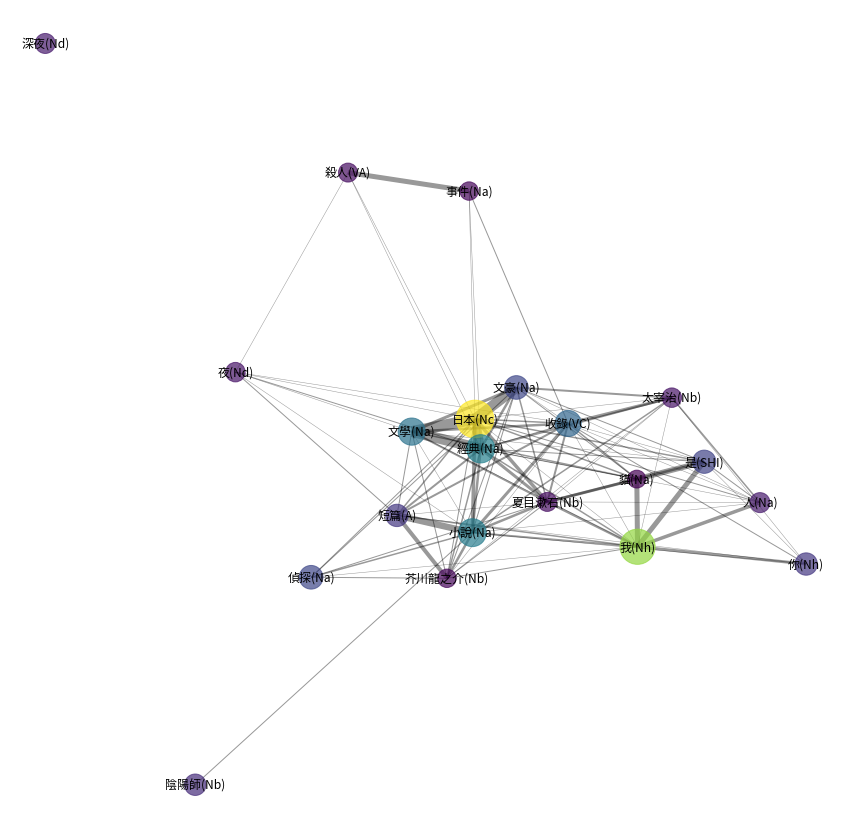

In [ ]:
G = nx.Graph()
G.nodes(data=True)

for pair in pairs:
#for pair in edges:
    node_x, node_y, node_x_cnt, node_y_cnt, jaccard = pair[:5]#[0], pair[1], pair[2], pair[3], pair[4]
    if not G.has_node(node_x):
        G.add_node(node_x, count=node_x_cnt)
    if not G.has_node(node_y):
        G.add_node(node_y, count=node_y_cnt)
    if not G.has_edge(node_x, node_y):
        G.add_edge(node_x, node_y, weight=jaccard)
    #else:
    #    print(pair)
        
plt.figure(figsize=(15,15))
_pos = nx.spring_layout(G, k=1)

node_size = [d['count']*20 for (n,d) in G.nodes(data=True)]
nx.draw_networkx_nodes(G, _pos, node_size=node_size, node_color=node_size, alpha=0.7)
nx.draw_networkx_labels(G, _pos)#, fontsize=14, font_family='Droid Sans Japanese')

edge_width = [d['weight']*0.5 for (u,v,d) in G.edges(data=True)]
nx.draw_networkx_edges(G, _pos, alpha=0.4, edge_color='black', width=edge_width)

plt.axis('off')
plt.show()

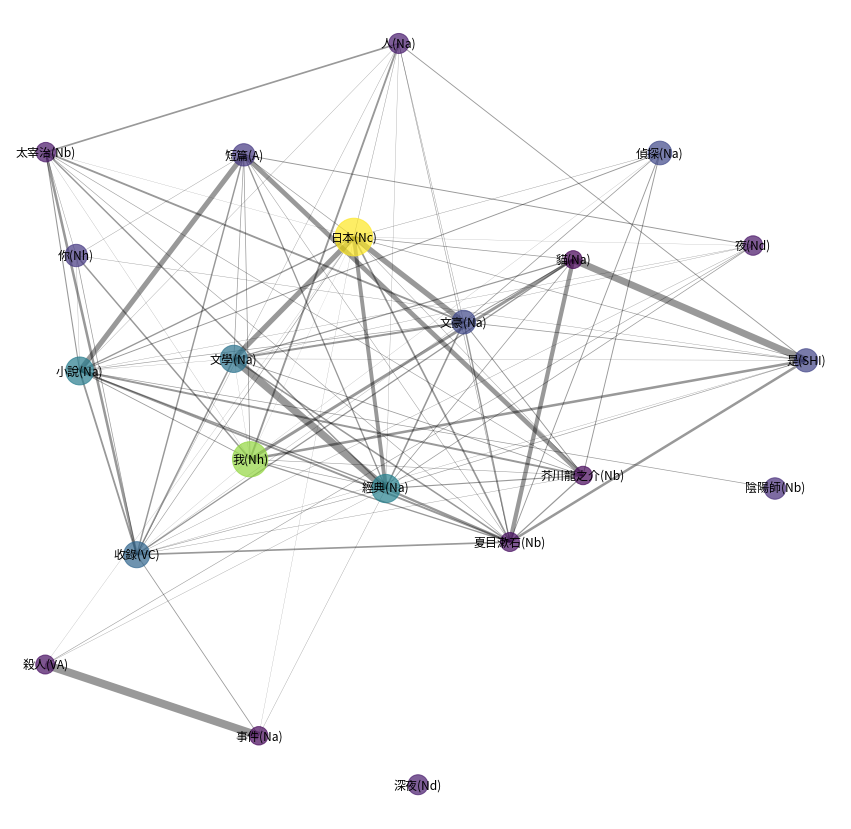

In [ ]:
G = nx.Graph()
G.nodes(data=True)

for pair in pairs:
#for pair in edges:
    node_x, node_y, node_x_cnt, node_y_cnt, jaccard = *pair[:4], pair[5]#[0], pair[1], pair[2], pair[3], pair[4]
    if not G.has_node(node_x):
        G.add_node(node_x, count=node_x_cnt)
    if not G.has_node(node_y):
        G.add_node(node_y, count=node_y_cnt)
    if not G.has_edge(node_x, node_y):
        G.add_edge(node_x, node_y, weight=jaccard)
    #else:
    #    print(pair)
        
plt.figure(figsize=(15,15))
_pos = nx.spring_layout(G, k=1)

node_size = [d['count']*20 for (n,d) in G.nodes(data=True)]
nx.draw_networkx_nodes(G, _pos, node_size=node_size, node_color=node_size, alpha=0.7)
nx.draw_networkx_labels(G, _pos)#, fontsize=14, font_family='Droid Sans Japanese')

edge_width = [d['weight']*20 for (u,v,d) in G.edges(data=True)]
nx.draw_networkx_edges(G, _pos, alpha=0.4, edge_color='black', width=edge_width)

plt.axis('off')
plt.show()